# Algoritmos por bloques

El propósito de estos apuntes es mostrar como afectar al tiempo de ejecución de una función el realizar una lectura por bloques de los elementos en memoria. En particular, estará centrado en la operación transpuesta de una matriz, y en el producto matriz-vector.

## Limpiar archivos

In [1]:
%%bash
if rm *.o *.c *.so; then
    echo 'LIMPIO'
else
    echo 'NO HABÍA ARCHIVOS QUE LIMPIAR'
fi

LIMPIO


## Dependencias

In [2]:
import numpy
import ctypes
import time
from statistics import mean
from utilities import filtro_mediana
import matplotlib.pyplot as plt
from numpy import asarray

In [3]:
def ptr2ptr(x):
    return (x.__array_interface__['data'][0] + numpy.arange(x.shape[0])*x.strides[0]).astype(numpy.uintp)

## Implementación en C de la Transpuesta en ambas formas

In [4]:
%%file libtranspose.c
void transposeclassic(double *A, double *AT, int N)
{
    for(int i = 0; i < N; i++) {
        for(int j = 0; j < N; j++) {
            AT[j+i*N] = A[i+j*N];
        }
    }   
}

void transposeblock(double *A, double *AT, int N, int block)
{
    for (int i = 0; i < N; i += block) {
        for (int j = 0; j < N; j += block) {
            for (int k = i; k < i + block; ++k) {
                for (int l = j; l < j + block; ++l) {
                    AT[k + l*N] = A[l + k*N];
                }
            }
        }
    }   
}

Writing libtranspose.c


In [5]:
! gcc -c libtranspose.c -o libtranspose.o
! gcc -shared libtranspose.o -o libtranspose.so

### Enlace a Python

In [6]:
def ctypes_libtranspose():
    # ruta de la shared library
    libtranspose = ctypes.CDLL('./libtranspose.so')
    
    # tipo de los argumentos de la forma sin bloques
    libtranspose.transposeclassic.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.double),
        numpy.ctypeslib.ndpointer(dtype=numpy.double),
        ctypes.c_int
    ]
    
    # tipo de los argumentos de la forma con bloques
    libtranspose.transposeblock.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.double),
        numpy.ctypeslib.ndpointer(dtype=numpy.double),
        ctypes.c_int,
        ctypes.c_int
    ]
    
    # se devuelve las funciones configuradas
    return libtranspose.transposeclassic, libtranspose.transposeblock

Instancias de las funciones

In [7]:
transposeclassic, transposeblock = ctypes_libtranspose()

### Error relativo

In [8]:
n = 2**14
A = numpy.random.rand(n,n)
Y = A.flatten()
At1 = numpy.zeros_like(A.flatten())
At2 = numpy.zeros_like(A.flatten())

In [9]:
transposeclassic(Y,At1,n)
# error relativo
numpy.linalg.norm(numpy.transpose(A).flatten()-At1)/numpy.linalg.norm(numpy.transpose(A).flatten())

0.0

In [10]:
transposeblock(Y,At2,n,2)
# error relativo
numpy.linalg.norm(numpy.transpose(A).flatten()-At2)/numpy.linalg.norm(numpy.transpose(A).flatten())

0.0

In [11]:
transposeblock(Y,At2,n,4)
# error relativo
numpy.linalg.norm(numpy.transpose(A).flatten()-At2)/numpy.linalg.norm(numpy.transpose(A).flatten())

0.0

In [12]:
transposeblock(Y,At2,n,8)
# error relativo
numpy.linalg.norm(numpy.transpose(A).flatten()-At2)/numpy.linalg.norm(numpy.transpose(A).flatten())

0.0

### Medida de tiempo al vuelo

In [13]:
%timeit -r 5 -n 1 transposeclassic(Y,At1,n)

5.71 s ± 402 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [14]:
%timeit -r 5 -n 1 transposeblock(Y,At2,n,2)

2.67 s ± 84.6 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [15]:
%timeit -r 5 -n 1 transposeblock(Y,At2,n,4)

1.91 s ± 40.2 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [16]:
%timeit -r 5 -n 1 transposeblock(Y,At2,n,8)

1.42 s ± 60.3 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [17]:
%timeit -r 5 -n 1 transposeblock(Y,At2,n,16)

2.87 s ± 43.9 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [18]:
del n
del A
del Y
del At1
del At2

Creo que voy a evitar los tamaños de bloque 2 y 16 :v

### Mediciones

In [19]:
ns = 2**numpy.arange(5,15)
veces = range(12)
ltb4 = []
ltb8 = []
lt = []
for n in ns:
    ltb4i = []
    ltb8i = []
    lti = []
    for _ in veces:
        # entradas
        A = numpy.random.rand(n,n)
        Y = A.flatten()
        # referencia
        Atn = numpy.transpose(A)
        Ytn = Atn.flatten()
        
        # para la forma sin bloques
        At = numpy.zeros_like(Ytn)
        # para bloque 4 
        At4 = numpy.zeros_like(Ytn)
        # para bloque 8
        At8 = numpy.zeros_like(Ytn)
        
        # 4
        tic = time.time()
        transposeblock(Y,At4,n,4)
        toc = time.time()
        ltb4i.append(toc-tic)
        
        # 8
        tic = time.time()
        transposeblock(Y,At8,n,8)
        toc = time.time()
        ltb8i.append(toc-tic)
        
        # sin bloques
        tic = time.time()
        transposeclassic(Y,At,n)
        toc = time.time()
        lti.append(toc-tic)
        
        del A
        del Ytn
        del At4
        del At8
        
    ltb4.append(mean(filtro_mediana(ltb4i,5)))
    ltb8.append(mean(filtro_mediana(ltb8i,5)))
    lt.append(mean(filtro_mediana(lti,5)))

### Resultados

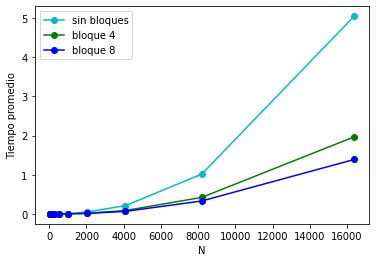

In [20]:
plt.plot(ns,lt,'-co',label='sin bloques')
plt.plot(ns,ltb4,'-go',label='bloque 4')
plt.plot(ns,ltb8,'-bo',label='bloque 8')
plt.xlabel('N')
plt.ylabel('Tiempo promedio')
plt.legend()

En la gráfica no se aprecia con mucho detalle la tendencia antes de `N=1024`. Entonces, se realizará un acercamiento para ver la tendencia en ese tramo.

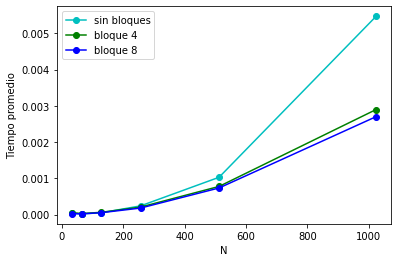

In [21]:
plt.plot(ns[:6],lt[:6],'-co',label='sin bloques')
plt.plot(ns[:6],ltb4[:6],'-go',label='bloque 4')
plt.plot(ns[:6],ltb8[:6],'-bo',label='bloque 8')
plt.xlabel('N')
plt.ylabel('Tiempo promedio')
plt.legend()

Para un `N` de `32` a `256` la forma con bloques parece tener la misma rapidez que la forma sin bloques :'v.

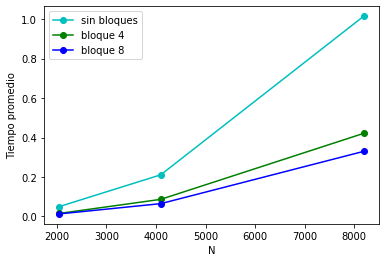

In [22]:
start=6
end=9
plt.plot(ns[start:end],lt[start:end],'-co',label='sin bloques')
plt.plot(ns[start:end],ltb4[start:end],'-go',label='bloque 4')
plt.plot(ns[start:end],ltb8[start:end],'-bo',label='bloque 8')
plt.xlabel('N')
plt.ylabel('Tiempo promedio')
plt.legend()

Para un tamagno de `N=2048` la forma con bloques de valor `4` y `8` tienen igual rendimiento luego de `N=4096` ya empiezan a diferenciarse.

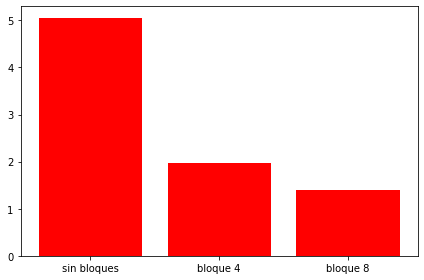

In [24]:
noms = ['sin bloques','bloque 4','bloque 8']
proms1 = [ 
    lt[9], 
    ltb4[9],
    ltb8[9]
]
plt.bar(noms,proms1,color='r')
plt.tight_layout()

En el último tamaño `N=16384`, se observa que la tendencia se mantiene. A pesar de que en tamaños pequeños la forma sin bloques es igual de rápida que la forma con bloques, se empleará la forma sin bloques como referencia para calcular el _speedup_.

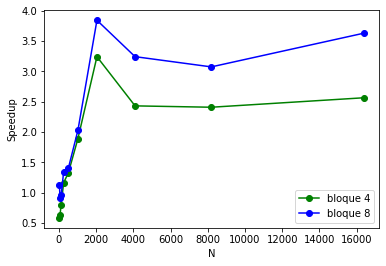

In [25]:
plt.plot(ns,asarray(lt)/asarray(ltb4),'-go',label='bloque 4')
plt.plot(ns,asarray(lt)/asarray(ltb8),'-bo',label='bloque 8')
plt.xlabel('N')
plt.ylabel('Speedup')
plt.legend()

La implementación por bloques mejora en los tamagnos desde `N=512` hasta que se llega a `N=2048`, luego el rendimiento decae hasta `N=8192` para mostrar una pequeña recuperación en `N=16384`. La forma con bloque de tamagno `8` presentó un mayor _speedup_. 

## Implementación en C del producto Matriz-Vector en ambas formas

In [26]:
%%file libmatvec.c
void matvecclassic(double *A, double *x, double *b, int N) {
    double tmp = 0.0;
    for(int i = 0; i < N; i++) {
        tmp = 0.0;
        for(int j = 0; j < N; j++) {
            tmp += A[i*N + j]*x[j];
        }
        b[i] = tmp;
    }   
}

void matvecblock(double *A, double *x, double *b, int N, int block)
{
    double tmp = 0.0;
    for (int i = 0; i < N; i += block) {
        for (int j = 0; j < N; j += block) {
            for (int k = i; k < i + block; ++k) {
                tmp = b[k];
                for (int l = j; l < j + block; ++l) {
                     tmp += A[k*N + l]*x[l];
                }
                b[k] = tmp;
            }
        }
    }   
}

Writing libmatvec.c


In [27]:
! gcc -c libmatvec.c -o libmatvec.o
! gcc -shared libmatvec.o -o libmatvec.so

### Enlace a Python

In [28]:
def ctypes_libmatvec():
    # ruta de la shared library
    libmatvec = ctypes.CDLL('./libmatvec.so')
    
    # tipo de los argumentos de la forma sin bloques
    libmatvec.matvecclassic.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.double),
        numpy.ctypeslib.ndpointer(dtype=numpy.double),
        numpy.ctypeslib.ndpointer(dtype=numpy.double),
        ctypes.c_int
    ]
    
    # tipo de los argumentos de la forma con bloques
    libmatvec.matvecblock.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.double),
        numpy.ctypeslib.ndpointer(dtype=numpy.double),
        numpy.ctypeslib.ndpointer(dtype=numpy.double),
        ctypes.c_int,
        ctypes.c_int
    ]
    
    # se devuelve las funciones configuradas
    return libmatvec.matvecclassic, libmatvec.matvecblock

In [29]:
matvecclassic, matvecblock = ctypes_libmatvec()

### Error relativo

In [30]:
N = 1024
A = numpy.random.rand(N,N)
x = numpy.random.rand(N,1)
bclassic = numpy.zeros_like(x)
bblock = numpy.zeros_like(x)
block = 16
matvecclassic(A.flatten(), x, bclassic, N)
matvecblock(A.flatten(), x, bblock, N, block)
numpy.linalg.norm(A.dot(x)-bclassic), numpy.linalg.norm(A.dot(x)-bblock)

(7.2694043471589955e-12, 7.2694043471589955e-12)

### Mediciones

In [31]:
ns = 2**numpy.arange(8,15)
veces = range(20)

In [32]:
ltb4 = []
ltb8 = []
ltb16 = []
lt = []
for n in ns:
    ltb4i = []
    ltb8i = []
    ltb16i = []
    lti = []
    for _ in veces:
        # entradas
        A = numpy.random.rand(n,n)
        Y = A.flatten()
        x = numpy.random.rand(n,1)
        
        # para la forma sin bloques
        bclassic = numpy.zeros_like(x)
        # para bloque 4 
        b4 = numpy.zeros_like(x)
        # para bloque 8
        b8 = numpy.zeros_like(x)
        # para bloque 16
        b16 = numpy.zeros_like(x)
        
        # 4
        tic = time.time()
        matvecblock(Y,x,b4,n,4)
        toc = time.time()
        ltb4i.append(toc-tic)
        
        # 8
        tic = time.time()
        matvecblock(Y,x,b8,n,8)
        toc = time.time()
        ltb8i.append(toc-tic)

        # 16
        tic = time.time()
        matvecblock(Y,x,b16,n,16)
        toc = time.time()
        ltb16i.append(toc-tic)
        
        # sin bloques
        tic = time.time()
        matvecclassic(Y,x,bclassic,n)
        toc = time.time()
        lti.append(toc-tic)
        
        del A
        del Y
        del x
        del bclassic
        del b4
        del b8
        del b16
    
    ltb4.append(mean(filtro_mediana(ltb4i,11)))
    ltb8.append(mean(filtro_mediana(ltb8i,11)))
    ltb16.append(mean(filtro_mediana(ltb16i,11)))
    lt.append(mean(filtro_mediana(lti,11)))

### Resultados

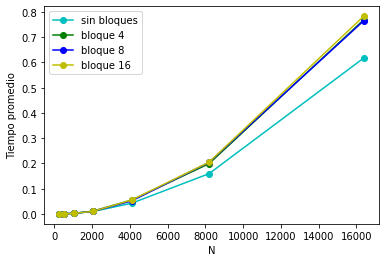

In [33]:
plt.plot(ns,lt,'-co',label='sin bloques')
plt.plot(ns,ltb4,'-go',label='bloque 4')
plt.plot(ns,ltb8,'-bo',label='bloque 8')
plt.plot(ns,ltb16,'-yo',label='bloque 16')
plt.xlabel('N')
plt.ylabel('Tiempo promedio')
plt.legend()

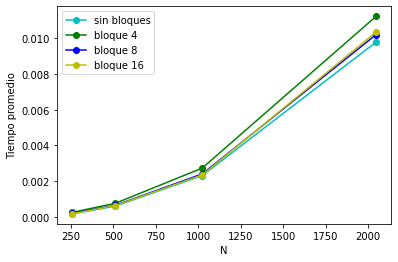

In [34]:
end=4
plt.plot(ns[:end],lt[:end],'-co',label='sin bloques')
plt.plot(ns[:end],ltb4[:end],'-go',label='bloque 4')
plt.plot(ns[:end],ltb8[:end],'-bo',label='bloque 8')
plt.plot(ns[:end],ltb16[:end],'-yo',label='bloque 16')
plt.xlabel('N')
plt.ylabel('Tiempo promedio')
plt.legend()

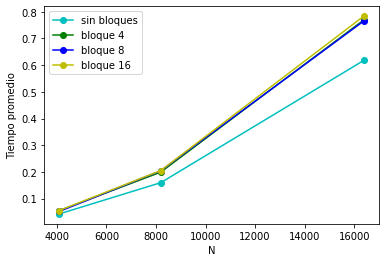

In [35]:
start=4
plt.plot(ns[start:],lt[start:],'-co',label='sin bloques')
plt.plot(ns[start:],ltb4[start:],'-go',label='bloque 4')
plt.plot(ns[start:],ltb8[start:],'-bo',label='bloque 8')
plt.plot(ns[start:],ltb16[start:],'-yo',label='bloque 16')
plt.xlabel('N')
plt.ylabel('Tiempo promedio')
plt.legend()

En el caso del producto matriz-vector siempre gana la versión sin bloques :'v. La pregunta es: ¿Por qué? o.O

## Implementación en C del producto Matriz-Matriz en ambas formas

In [36]:
%%file libmatmat.c
void matmatclassic(double **A, double **B, double **C, int N) 
{
    double tmp = 0.0;
    for(int i = 0; i < N; i++)
    {
        for(int j = 0; j < N; j++)
        {
            tmp = 0.0;
            for(int k = 0; k < N; k++)
            {
                tmp += A[i][k] * B[k][j];
            }
            C[i][j] = tmp;
        }
    }
}

void matmatblock(double **A, double **B, double **C, int N, int block)
{
    double tmp = 0.0;
    for(int i = 0; i < N; i+=block)
    {
        for(int j = 0; j < N; j+=block)
        {
            for(int k = 0; k < N; k+=block)
            {
                for(int ii = i; ii < i + block; ii++)
                {
                    for(int jj = j; jj < j + block; jj++)
                    {
                        tmp = C[ii][jj];
                        for(int kk = k; kk < k + block; kk++)
                        {
                            tmp += A[ii][kk]*B[kk][jj];
                        }
                        C[ii][jj] = tmp;
                    }
                }
            }
        }
    }
}

Writing libmatmat.c


In [37]:
! gcc -c libmatmat.c -o libmatmat.o
! gcc -shared libmatmat.o -o libmatmat.so

### Enlace a Python

In [38]:
def ctypes_libmatmat():
    # ruta de la shared library
    libmatmat = ctypes.CDLL('./libmatmat.so')
    
    # tipo de los argumentos de la forma sin bloques
    libmatmat.matmatclassic.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        ctypes.c_int
    ]
    
    # tipo de los argumentos de la forma con bloques
    libmatmat.matmatblock.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        numpy.ctypeslib.ndpointer(dtype=numpy.uintp, ndim=1, flags='C'),
        ctypes.c_int
    ]
    
    # se devuelve las funciones configuradas
    return libmatmat.matmatclassic, libmatmat.matmatblock

matmatclassic, matmatblock = ctypes_libmatmat()

# solo para que la implementación sea más cercana al paradigma de programación de Python

def cmatmatclassic(A,B):
    n, _ = A.shape
    C = numpy.zeros_like(A)
    Cpp = ptr2ptr(C)
    App = ptr2ptr(A)
    Bpp = ptr2ptr(B)
    matmatclassic(App,Bpp,Cpp,n)
    return C

def cmatmatblock(A,B,block):
    n, _ = A.shape
    C = numpy.zeros_like(A)
    Cpp = ptr2ptr(C)
    App = ptr2ptr(A)
    Bpp = ptr2ptr(B)
    matmatblock(App,Bpp,Cpp,n,block)
    return C

### Error Relativo

In [39]:
n = 2048
A = numpy.random.rand(n,n)
B = numpy.random.rand(n,n)
C = numpy.dot(A,B)

In [40]:
Cclassic = cmatmatclassic(A,B)
numpy.linalg.norm(Cclassic-C)/numpy.linalg.norm(C)

1.1363558107530474e-15

In [41]:
Cblock = cmatmatblock(A,B,2)
numpy.linalg.norm(Cblock-C)/numpy.linalg.norm(C)

1.1363558107530474e-15

In [42]:
Cblock = cmatmatblock(A,B,4)
numpy.linalg.norm(Cblock-C)/numpy.linalg.norm(C)

1.1363558107530474e-15

In [43]:
Cblock = cmatmatblock(A,B,8)
numpy.linalg.norm(Cblock-C)/numpy.linalg.norm(C)

1.1363558107530474e-15

In [44]:
Cblock = cmatmatblock(A,B,16)
numpy.linalg.norm(Cblock-C)/numpy.linalg.norm(C)

1.1363558107530474e-15

El error relativo es chiquitito \\:v/

### Medición de tiempo al vuelo

No ejecuten las celdas de esta sección, a menos que quieran esperar poco más de 30 minutos 😖

In [45]:
n = 2048
A = numpy.random.rand(n,n)
B = numpy.random.rand(n,n)

In [46]:
%timeit -r 5 -n 1 cmatmatclassic(A,B)

1min 41s ± 1.2 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [47]:
%timeit -r 5 -n 1 cmatmatblock(A,B,2)

1min 35s ± 46 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [48]:
%timeit -r 5 -n 1 cmatmatblock(A,B,4)

38.5 s ± 846 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [49]:
%timeit -r 5 -n 1 cmatmatblock(A,B,8)

27.3 s ± 236 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [50]:
%timeit -r 5 -n 1 cmatmatblock(A,B,16)

24.4 s ± 229 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


Parece que usar un bloque de tamaño 2 no ofrece mucha diferencia respecto de la forma sin bloques, y que un bloque de tamaño 16 tampoco se distancia mucho de un bloque de tamaño 8.

### Mediciones

In [51]:
ns = 2**numpy.arange(5,11)
veces = range(12)

lc = []
lb4 = []
lb8 = []
for n in ns:
    lci = []
    lb4i = []
    lb8i = []
    for _ in veces:
        # entradas
        A = numpy.random.rand(n,n)
        B = numpy.random.rand(n,n)

        # Classic
        tic = time.time()
        Cc = cmatmatclassic(A,B)
        toc = time.time()
        lci.append(toc-tic)

        # 4
        tic = time.time()
        C4 = cmatmatblock(A,B,4)
        toc = time.time()
        lb4i.append(toc-tic)

        # 8
        tic = time.time()
        C8 = cmatmatblock(A,B,8)
        toc = time.time()
        lb8i.append(toc-tic)

    lc.append(mean(filtro_mediana(lci,5)))
    lb4.append(mean(filtro_mediana(lb4i,5)))
    lb8.append(mean(filtro_mediana(lb8i,5)))

### Gráficos

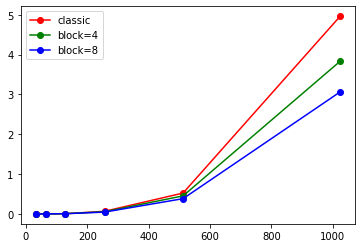

In [52]:
plt.plot(ns,lc,'r-o',label='classic')
plt.plot(ns,lb4,'g-o',label='block=4')
plt.plot(ns,lb8,'b-o',label='block=8')
plt.legend()
plt.show()

En los primeros tamaños no se aprecia la tendencia 😅. 

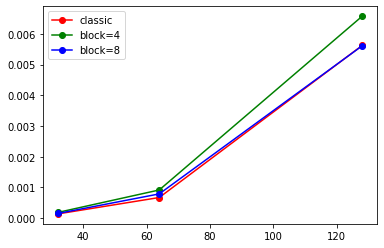

In [53]:
end=3
plt.plot(ns[:end],lc[:end],'r-o',label='classic')
plt.plot(ns[:end],lb4[:end],'g-o',label='block=4')
plt.plot(ns[:end],lb8[:end],'b-o',label='block=8')
plt.legend()
plt.show()

Para $N=32$ hasta $N=128$ la forma clásica es más rápida que la forma con bloques para un bloque de tamagno `4` e igual de rápida para un bloque de tamagno `8` 😬.

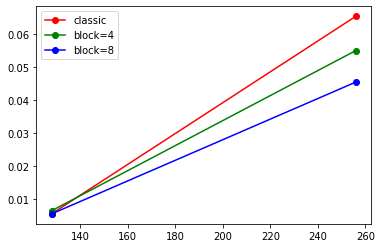

In [54]:
start=2
end=4
plt.plot(ns[start:end],lc[start:end],'r-o',label='classic')
plt.plot(ns[start:end],lb4[start:end],'g-o',label='block=4')
plt.plot(ns[start:end],lb8[start:end],'b-o',label='block=8')
plt.legend()
plt.show()

Recién en el cambio de $N=128$ a $N=256$ la forma clásica es más lenta que las otras.

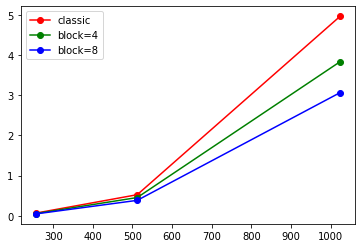

In [55]:
start=3
plt.plot(ns[start:],lc[start:],'r-o',label='classic')
plt.plot(ns[start:],lb4[start:],'g-o',label='block=4')
plt.plot(ns[start:],lb8[start:],'b-o',label='block=8')
plt.legend()
plt.show()

De $N=256$ en adelante la tendencia se mantiene

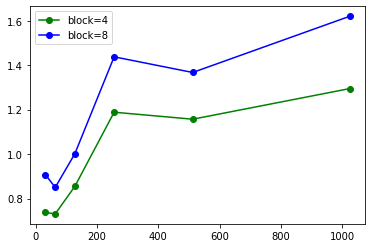

In [56]:
plt.plot(ns,numpy.asarray(lc)/numpy.asarray(lb4),'g-o',label='block=4')
plt.plot(ns,numpy.asarray(lc)/numpy.asarray(lb8),'b-o',label='block=8')
plt.legend()
plt.show()

En conformidad con lo observado en la gráfica de tiempos, hay pérdida al principio, pero luego de $N=256$ ya hay ganancia. Hubiera sido chévere probar con tamaño de bloque 16, pero me da flojera. Inténtalo tú 😄